### Look at outputs from a inventory initialization

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

import functions_py.fates_xarray_functions as fa


### Load FATES

In [2]:
# fates dbh natural
fates_dbh_n = '/pscratch/sd/j/jneedham/elm_runs/bci/bci_inv_init_dbh_natural.Eb8be65d66e-F35a6abd7.2023-11-02/run/bci_inv_init_dbh_natural.Eb8be65d66e-F35a6abd7.2023-11-02.elm.h0.sofar.nc'
fates_dbh_n = xr.open_dataset(fates_dbh_n,  decode_times=False)

# fates height natural
fates_h_n = '/pscratch/sd/j/jneedham/elm_runs/bci/bci_inv_init_height_natural.Eb8be65d66e-F35a6abd7.2023-11-02/run/bci_inv_init_height_natural.Eb8be65d66e-F35a6abd7.2023-11-02.elm.h0.sofar.nc'
fates_h_n = xr.open_dataset(fates_h_n,  decode_times=False)

# fates height plantation
fates_h_p = '/pscratch/sd/j/jneedham/elm_runs/bci/bci_inv_init_height_plantation.Eb8be65d66e-F35a6abd7.2023-11-02/run/bci_inv_init_height_plantation.Eb8be65d66e-F35a6abd7.2023-11-02.elm.h0.sofar.nc'
fates_h_p = xr.open_dataset(fates_h_p,  decode_times=False)

time = fates_dbh_n.variables['time'] / 365.
cohort_size_bins = fates_dbh_n.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

In [3]:
print(cohort_size_bins)

<xarray.IndexVariable 'fates_levscls' (fates_levscls: 13)>
array([  0.,   5.,  10.,  15.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,
       100.], dtype=float32)
Attributes:
    long_name:  FATES diameter size class lower bound
    units:      cm


### AGB

In [5]:
AGB_dbh_n = fates_dbh_n.FATES_VEGC_ABOVEGROUND
AGB_h_n = fates_h_n.FATES_VEGC_ABOVEGROUND
AGB_h_p = fates_h_p.FATES_VEGC_ABOVEGROUND

''

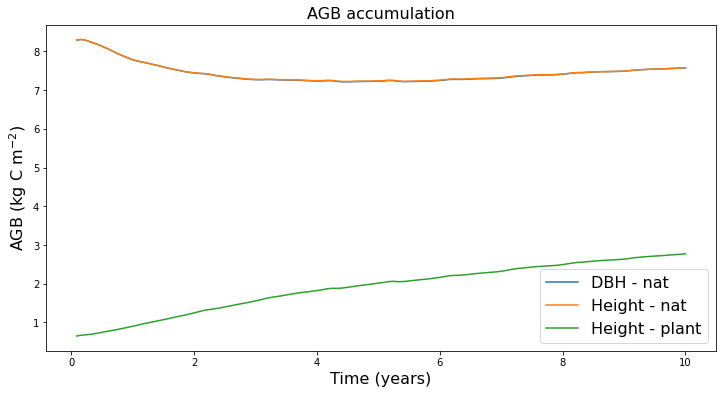

In [6]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f1ax0.plot(time, AGB_dbh_n,  label = 'DBH - nat') 
f1ax0.plot(time, AGB_h_n,  label = 'Height - nat') 
f1ax0.plot(time, AGB_h_p,  label = 'Height - plant')

f1ax0.legend(fontsize=16)
   
f1ax0.set_title(r'AGB accumulation', fontsize = 16)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 16)
f1ax0.set_xlabel(r'Time (years)', fontsize = 16)    
 
;

### NPLANT by size by time

In [7]:
nplant_c_dbh_n = fa.scpf_to_scls_by_pft(fates_dbh_n.FATES_NPLANT_CANOPY_SZPF, fates_dbh_n).isel(fates_levpft=0) * 10000
nplant_u_dbh_n = fa.scpf_to_scls_by_pft(fates_dbh_n.FATES_NPLANT_USTORY_SZPF, fates_dbh_n).isel(fates_levpft=0) * 10000

nplant_c_h_n = fa.scpf_to_scls_by_pft(fates_h_n.FATES_NPLANT_CANOPY_SZPF, fates_h_n).isel(fates_levpft=0) * 10000
nplant_u_h_n = fa.scpf_to_scls_by_pft(fates_h_n.FATES_NPLANT_USTORY_SZPF, fates_h_n).isel(fates_levpft=0) * 10000

nplant_c_h_p = fa.scpf_to_scls_by_pft(fates_h_p.FATES_NPLANT_CANOPY_SZPF, fates_h_p).isel(fates_levpft=0) * 10000
nplant_u_h_p = fa.scpf_to_scls_by_pft(fates_h_p.FATES_NPLANT_USTORY_SZPF, fates_h_p).isel(fates_levpft=0) * 10000

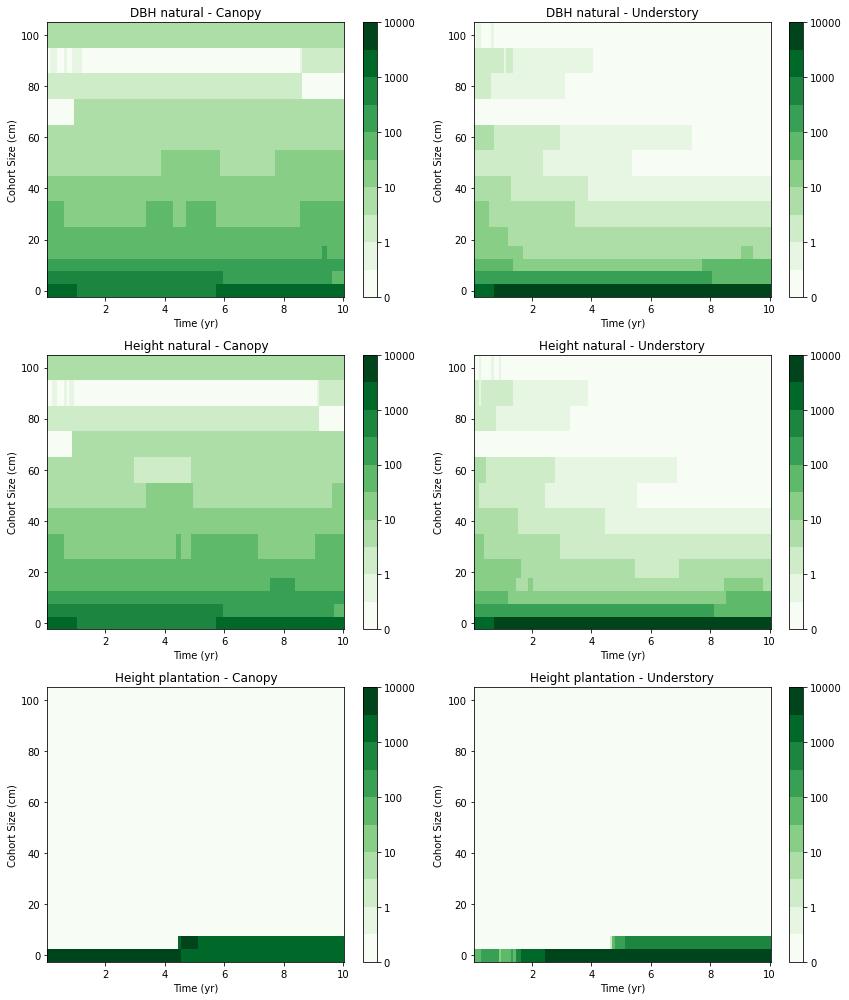

In [8]:
levels = np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.]) # do a pseudo-log scale here
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# set up the page
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3),(f2ax4,f2ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

im = f2ax0.pcolormesh(time, cohort_size_bins, np.squeeze(nplant_c_dbh_n).transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax0)
f2ax0.set_title(r'DBH natural - Canopy')
f2ax0.set_xlabel('Time (yr)')
f2ax0.set_ylabel('Cohort Size (cm)')

im = f2ax1.pcolormesh(time, cohort_size_bins, np.squeeze(nplant_u_dbh_n).transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax1)
f2ax1.set_title(r'DBH natural - Understory')
f2ax1.set_xlabel('Time (yr)')
f2ax1.set_ylabel('Cohort Size (cm)')

im = f2ax2.pcolormesh(time, cohort_size_bins, np.squeeze(nplant_c_h_n).transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax2)
f2ax2.set_title(r'Height natural - Canopy')
f2ax2.set_xlabel('Time (yr)')
f2ax2.set_ylabel('Cohort Size (cm)')

im = f2ax3.pcolormesh(time, cohort_size_bins, np.squeeze(nplant_u_h_n).transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax3)
f2ax3.set_title(r'Height natural - Understory')
f2ax3.set_xlabel('Time (yr)')
f2ax3.set_ylabel('Cohort Size (cm)')

im = f2ax4.pcolormesh(time, cohort_size_bins, np.squeeze(nplant_c_h_p).transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax4)
f2ax4.set_title(r'Height plantation - Canopy')
f2ax4.set_xlabel('Time (yr)')
f2ax4.set_ylabel('Cohort Size (cm)')

im = f2ax5.pcolormesh(time, cohort_size_bins, np.squeeze(nplant_u_h_p).transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax5)
f2ax5.set_title(r'Height plantation - Understory')
f2ax5.set_xlabel('Time (yr)')
f2ax5.set_ylabel('Cohort Size (cm)')

# show the plot
fig2.tight_layout()
plt.show()